In [1]:
# installing the Kaggle library
!pip install kaggle

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Kaggle api
!kaggle competitions download -c dogs-vs-cats

 99% 801M/812M [00:07<00:00, 148MB/s]
100% 812M/812M [00:07<00:00, 111MB/s]


In [4]:
#our data is zipped , we need to unzip it
from zipfile import ZipFile
file_name = "/content/dogs-vs-cats.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


In [5]:
#we need train.zip , we need to unzip it again
from zipfile import ZipFile
file_name = "/content/train.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Done")

Done


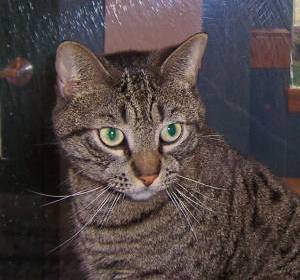

In [6]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/train/cat.1.jpg")
cv2_imshow(img)

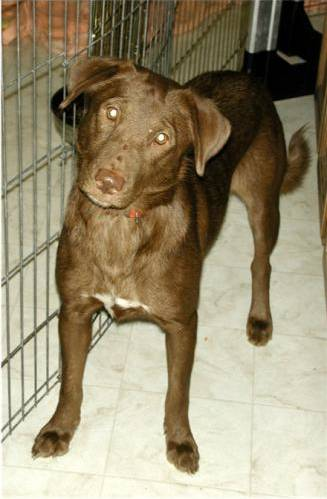

In [7]:
img = cv2.imread("/content/train/dog.1.jpg")
cv2_imshow(img)

In [8]:
import pandas as pd
import numpy as np
import os

In [9]:
output_dir = '/content/resized_images/'
os.makedirs(output_dir, exist_ok=True)

In [10]:
#since, we have 25000 dataset, and since we are going to use Trasfer Learning
#we just need 2000 data
#so lets just take the first 2000 data and resize it, and store it in another dataset
file_names = os.listdir('/content/train')
labels = []
for i in range(2000):
  img_path = '/content/train/'+file_names[i]
  img = cv2.imread(img_path)
  img = cv2.resize(img,(224,224))
  cv2.imwrite('/content/resized_images/'+file_names[i],img)
  if file_names[i][0:3] == 'cat':
    labels.append(0)
  else:
    labels.append(1)

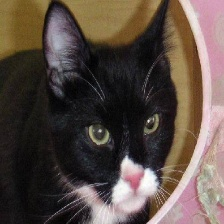

In [11]:
#lets check on of the dog and cat image
img = cv2.imread('/content/resized_images/cat.10001.jpg')
cv2_imshow(img)

In [12]:
#lets check how much do we have dog and cat in 2000 samples we took
values, count = np.unique(labels, return_counts=True)
print(values)
print(count)

[0 1]
[ 998 1002]


In [17]:
#we have somewhat balanced data
#now, lets read data from the resized folder
data = []
for i in range(2000):
  img_path = '/content/resized_images/'+file_names[i]
  img = cv2.imread(img_path)
  img = img/255
  img = np.array(img)
  data.append(img)

In [18]:
data = np.array(data)
labels = np.array(labels)

In [22]:
print(labels.shape)
print(data.shape)
print(labels.dtype)
print(data.dtype)
# print(data)
print(type(labels))

(2000,)
(2000, 224, 224, 3)
int64
float64
<class 'numpy.ndarray'>


In [23]:
#lets split the data into train and test
from sklearn.model_selection import train_test_split
x = data
y = labels
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1600, 224, 224, 3) (400, 224, 224, 3) (1600,) (400,)


In [24]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

In [25]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape=(224,224,3), trainable=False)

In [27]:
!pip install tf_keras

In [28]:
import tf_keras

In [29]:
num_of_classes = 2

model = tf_keras.Sequential([

    pretrained_model,
    tf_keras.layers.Dense(num_of_classes)

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [30]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [31]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
50/50 [==============================] - 66s 1s/step - loss: 0.1908 - acc: 0.9244
Epoch 2/5
50/50 [==============================] - 60s 1s/step - loss: 0.0606 - acc: 0.9806
Epoch 3/5
50/50 [==============================] - 58s 1s/step - loss: 0.0463 - acc: 0.9850
Epoch 4/5
50/50 [==============================] - 60s 1s/step - loss: 0.0353 - acc: 0.9925
Epoch 5/5
50/50 [==============================] - 58s 1s/step - loss: 0.0283 - acc: 0.9931


In [32]:
loss, accuracy = model.evaluate(x_test, y_test)
print(loss, accuracy)

13/13 [==============================] - 16s 1s/step - loss: 0.0486 - acc: 0.9800
0.048555150628089905 0.9800000190734863


In [33]:
#lets predict on the test data and check
y_test_pred = model.predict(x_test)

13/13 [==============================] - 17s 1s/step


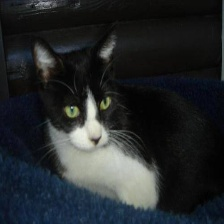

In [36]:
#lets check it for the first image in the x_test
cv2_imshow(x_test[0]*255)

In [39]:
if np.argmax(y_test_pred[0])==0:
  print("Cat")
else:
  print("Dog")

Cat


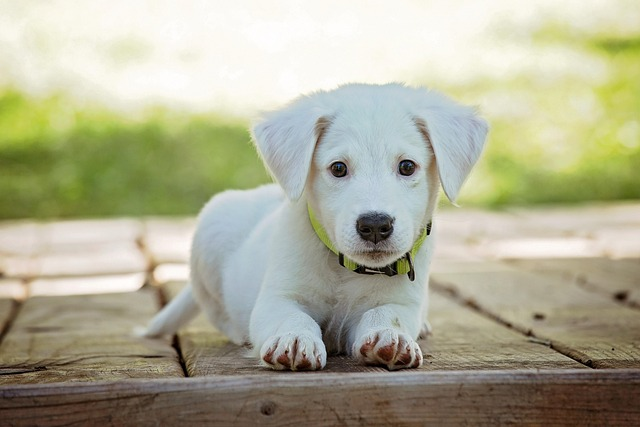

In [51]:
#a random dog picture has been downloaded, lets see how its works for it
img = cv2.imread('/content/puppy-1903313_640.jpg')
cv2_imshow(img)

In [54]:
img.shape

(224, 224, 3)

In [56]:
img = cv2.resize(img,(224,224))
img.shape

(224, 224, 3)

In [59]:
img = img/255
img = np.array(img)
img = np.reshape(img, (1,224,224,3))
img.shape

(1, 224, 224, 3)

In [61]:
if np.argmax(model.predict(img))==0:
  print("Cat")
else:
  print("Dog")

1/1 [==============================] - 0s 90ms/step
Dog
